In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input,\
Flatten, Dense, MaxPool2D
import os
import sys
import numpy as np

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'code_files',
 'Crack detection.ipynb',
 'images',
 'predict',
 'Results']

In [3]:
# model = Sequential([
#     Input(shape = (227, 227, 3)),
#     Conv2D(32, 3, padding = 'same', strides = 1, activation = 'relu'),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Dropout(0.5),
#     Conv2D(64, 3, padding = 'same', strides = 1, activation = 'relu'),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Dropout(0.5),
#     Conv2D(128, 3, padding = 'same', strides = 1, activation = 'relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     GlobalAveragePooling2D(),
#     Dense(64, activation = 'relu'),
#     Dense(1, activation = 'softmax')
# ])

# model.compile(
#     metrics = ['accuracy'],
#     optimizer = 'adam',
#     loss = 'BinaryCrossentropy'
# )

In [3]:
input_layer = Input(shape=(227,227,3))
x = Conv2D(16,3,activation="relu")(input_layer)
x = MaxPool2D((2,2))(x)

x = Conv2D(32,3,activation="relu")(x)
x = MaxPool2D((2,2))(x)
x = GlobalAveragePooling2D()(x)

output = Dense(1,activation="sigmoid")(x)

model=tf.keras.Model(inputs = [input_layer], outputs = [output])

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 225, 225, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33    

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            'images',
            labels = 'inferred',
            label_mode = 'binary',
            color_mode = 'rgb',
            batch_size = 32,
            shuffle = True,
            image_size = (227, 227),
            validation_split = 0.1,
            subset = 'training',
            seed = 123,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            'images',
            labels = 'inferred',
            label_mode = 'binary',
            color_mode = 'rgb',
            batch_size = 32,
            shuffle = True,
            image_size = (227, 227),
            validation_split = 0.1,
            subset = 'validation',
            seed = 123,
)

Found 40000 files belonging to 2 classes.
Using 36000 files for training.
Found 40000 files belonging to 2 classes.
Using 4000 files for validation.


In [7]:
def preprocess(x, y):
    image = x/ 255.0
    return image, y

In [8]:
train_ds, val_ds = train_ds.map(preprocess), val_ds.map(preprocess)

In [9]:
model.fit(train_ds, epochs = 10, verbose = 1, validation_data = val_ds,
         callbacks = [tf.keras.callbacks.ModelCheckpoint('model_saves', 'val_loss', save_best_only = True,),
                     tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    min_delta=0,
                                                    patience=1,
                                                    verbose=0,
                                                    mode="auto",
                                                    baseline=None,
                                                    restore_best_weights=True,)])

Epoch 1/10
1125/1125 [==============================] - 79s 67ms/step - loss: 0.5802 - accuracy: 0.6860 - val_loss: 0.2296 - val_accuracy: 0.9507
INFO:tensorflow:Assets written to: model_saves\assets
Epoch 2/10
1125/1125 [==============================] - 66s 58ms/step - loss: 0.2142 - accuracy: 0.9408 - val_loss: 0.1820 - val_accuracy: 0.9420
INFO:tensorflow:Assets written to: model_saves\assets
Epoch 3/10
1125/1125 [==============================] - 67s 59ms/step - loss: 0.1646 - accuracy: 0.9561 - val_loss: 0.1396 - val_accuracy: 0.9620
INFO:tensorflow:Assets written to: model_saves\assets
Epoch 4/10
1125/1125 [==============================] - 69s 62ms/step - loss: 0.1329 - accuracy: 0.9639 - val_loss: 0.1255 - val_accuracy: 0.9592
INFO:tensorflow:Assets written to: model_saves\assets
Epoch 5/10
1125/1125 [==============================] - 67s 59ms/step - loss: 0.1162 - accuracy: 0.9657 - val_loss: 0.1222 - val_accuracy: 0.9528
INFO:tensorflow:Assets written to: model_saves\assets


In [14]:
model.evaluate(val_ds)

125/125 [==============================] - 5s 38ms/step - loss: 0.0904 - accuracy: 0.9768


[0.0904291644692421, 0.9767500162124634]

In [5]:
model_loaded = tf.keras.models.load_model(f'code_files/neural network')

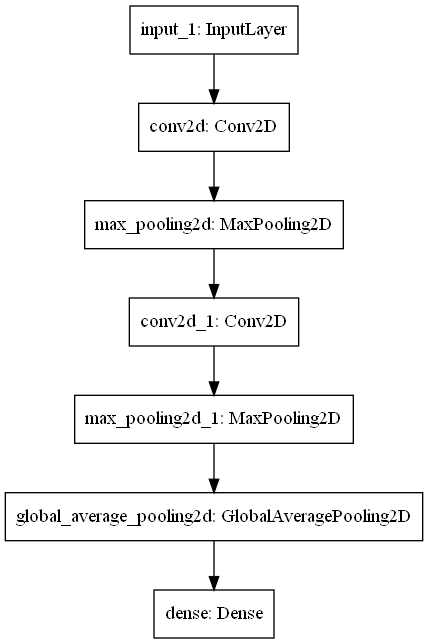

In [6]:
tf.keras.utils.plot_model(model_loaded)

In [19]:
model_loaded.evaluate(val_ds)

125/125 [==============================] - 5s 37ms/step - loss: 0.0904 - accuracy: 0.9768


[0.09042918682098389, 0.9767500162124634]

In [28]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs= [self.model.get_layer(self.layerName).output, self.model.output]
        )

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [22]:
model_loaded.get_layer('conv2d_1')

In [23]:
import cv2

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = load_img(r"Sutta Reddy/Positive/00001.jpg", target_size=(227, 227))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

preds = model.predict(image)
i = np.argmax(preds[0])

In [33]:
classes = ['Positive', 'Negative']

In [34]:
label = classes[i]

In [29]:
cam = GradCAM(model_loaded, i)
heatmap = cam.compute_heatmap(image)

In [31]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
orig = cv2.imread("Sutta Reddy/Positive/00001.jpg")
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [38]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
# output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()